# Analysis of results from simulated data
Deeper look into a model's performance on simulated data.

In [1]:
# Imports
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from master_scripts.data_functions import (load_experiment, get_git_root, separation_distance, energy_difference,
                                           relative_energy, event_indices, normalize_image_data)
from master_scripts.analysis_functions import (doubles_classification_stats)
%load_ext autoreload
%autoreload 2
repo_root = get_git_root()

## Data and experiment import
Load the image data and split into training and validation sets. Since we specify the random seed, we can
reproduce the exact same data the model was originally validated on to explore it.

In [2]:
images = np.load(repo_root + "data/simulated/images_full_pixelmod.npy")
positions = np.load(repo_root + "data/simulated/positions_full.npy")
energies = np.load(repo_root + "data/simulated/energies_full.npy")
labels = np.load(repo_root + "data/simulated/labels_full.npy")

## Add dead or bad pixels to simulated data

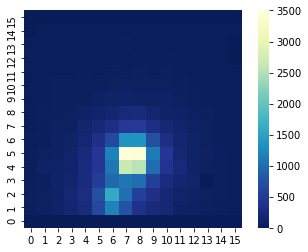

In [7]:
ax = plt.gca()
image = images[0]
image[3, 13] = 0
image[0, :] = 0
image[15, :] = 0
sns.heatmap(image.reshape((16, 16)), square=True, cmap="YlGnBu_r", ax=ax)
ax.invert_yaxis()
#ax.plot(3, 13, 'rx')

In [164]:
# Load experiment and associated model (must be a saved model instance complete with weights)
experiment_id = "40350020681b"
experiment = load_experiment(experiment_id)
model = tf.keras.models.load_model(repo_root + "models/" + experiment_id + ".h5")
# Print experiment metrics
print("==== Experiment metrics")
print(json.dumps(experiment["metrics"], indent=2))
print("====")

==== Experiment metrics
{
  "accuracy_score": 0.9832547368421053,
  "confusion_matrix": {
    "TN": 236703,
    "FP": 829,
    "FN": 7125,
    "TP": 230343
  },
  "f1_score": 0.983027483782861,
  "matthews_corrcoef": 0.966849143280241,
  "roc_auc_score": 0.9930843227110178
}
====


## Predict on validation data

In [165]:
x_idx = np.arange(len(images))
train_idx, val_idx = train_test_split(
    x_idx,
    random_state=experiment['experiment_config']['random_seed']
)   
# Predict on the validation set
prediction = model.predict(normalize_image_data(images[val_idx]))
val_pred = (prediction > 0.5).astype(int)

# Descriptive statistics on validation data

In [166]:
# Load dataframe
dstats = doubles_classification_stats(positions[val_idx], energies[val_idx], val_pred)

In [167]:
# Group by close events, then by which class the event was classified as
group = dstats.groupby(["close", "classification"])
# Get statistics for the relevant columns. Percentiles of 0.5 is interpreted as the median value
group.describe(include=["float"], percentiles=[0.5]).applymap('{:.3f}'.format)

separation distance                                      \
                                   count   mean    std    min    50%     max   
close classification                                                           
False 0                         5113.000  4.361  3.319  1.000  3.231  18.195   
      1                       229081.000  7.829  3.543  1.000  7.667  19.713   
True  0                         2012.000  0.646  0.235  0.021  0.676   1.000   
      1                         1262.000  0.695  0.233  0.021  0.737   1.000   

                     relative energy                                   \
                               count     mean       std    min    50%   
close classification                                                    
False 0                     5113.000  190.696  3399.306  0.000  1.292   
      1                   229081.000    2.538     7.535  0.003  1.000   
True  0                     2012.000    6.777    51.125  0.001  0.992   
      1                     1262.000    1.227     2.243  0.171  0.995   

                                 energy difference                       \
                             max             count   mean    std    min   
close classification                                                      
False 0               228094.700          5113.000  0.548  0.273  0.000   
      1                  535.828        229081.000  0.328  0.232  0.000   
True  0                 1449.956          2012.000  0.374  0.248  0.000   
      1                   76.363          1262.000  0.284  0.200  0.000   

                                    
                        50%    max  
close classification                
False 0               0.576  0.996  
      1               0.289  0.993  
True  0               0.339  0.992  
      1               0.250  0.829

# Distributions and scatterplot

### Comparing correct and misclassified double events

In [ ]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, np.amax(energy_diff_test), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Distribution of separation distances\n for classified double events")
ax[0].set_xlabel("Separation distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()
ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].set_title("Distribution of relative energy \n for classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()
fig.savefig(FIGURE_PATH+net+"_relative_test_compare.pdf", format="pdf")

In [ ]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, 10, 0.1)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
#ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Distribution of Relative distances\n for classified double events")
ax[0].set_xlabel("Relative distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()
#ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
#ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], label="wrong")
ax[1].set_title("Distribution of relative energy \n for classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()
fig.savefig(FIGURE_PATH+net+"_relative_test_compare.pdf", format="pdf")

### Scatterplot relative distance vs. relative energy

In [ ]:
plt.scatter(
    rel_distance_test[double_indices][wrong_doubles], 
    rel_energy_test[double_indices][wrong_doubles],
    marker='.',
    )
plt.title("Separation distance vs. relative energy for misclassified double events")
plt.xlabel("Separation distance [mm]")
plt.ylabel("Relative energy")
plt.show()

# Distribution of position around highest intensity pixel
In previous work data analysis showed that most event positions are within the highest intensity pixel,
and all (verify!) events are within the two highest intensity pixels,
It might be reasonable to look at how the predicted positions are distributed around the highest intensity
pixel.

In [ ]:
imgs = images[single_indices].reshape(images[single_indices].shape[0],16,16)

# get index of highest energy pixel
print(np.unravel_index(np.argmax(imgs[0], axis=None), imgs[0].shape))
fix, ax = plt.subplots()
ax.imshow(imgs[0])
ax.plot(0,0, 'rx')

In [ ]:
config = {
    "DATA_PATH": "../../data/real/anodedata.txt",              
    "MODEL_PATH": "../../data/output/models/",                
    "CLASSIFIER": "Project-0.97.hdf5",                      
    "SINGLE_ENERGY_MODEL": "single_energy_model_name.hdf5",    
    "SINGLE_POSITION_MODEL": "single_position_model_name.hdf5",
    "DOUBLE_ENERGY_MODEL": "double_energy_model_name.hdf5",    
    "DOUBLE_POSITION_MODEL": "double_position_model_name.hdf5" 
}

data = import_real_data(config)
print(data['image'].type)
